In [48]:
from keras.layers import TimeDistributed,LSTM,Conv1D,Dense,Flatten,ConvLSTM2D,MaxPooling1D, Dropout
from tensorflow_model_optimization.sparsity import keras as sparsity
from sklearn.experimental import enable_iterative_imputer
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.model_selection import KFold 
from IPython.display import clear_output
from scipy.interpolate import interp1d
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
from scipy import stats 
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import math
import csv

In [49]:
def replace_nan(x):
    if x==" ":
        return np.nan
    else :
        return float(x)

def norm(x, train_mean, train_std):
    return (x - train_mean) / train_std

In [53]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
features = ["temp","precip","rel_humidity","wind_dir","wind_spd","atmos_press"]
for feature in features : 
    train[feature] = train[feature].apply(lambda x: [ replace_nan(X) for X in x.replace("nan"," ").split(",")])
    test[feature] = test[feature].apply(lambda x: [ replace_nan(X)  for X in x.replace("nan"," ").split(",")])

patterns =  len(train['temp'])
entries =  len(train['temp'][0])
num_features = len(features)
labels = np.array(train['target'])
count = 0
inputs = [0, 0, 0, 0, 0, 0]
for F in features:
    with open(F + '.txt', 'r') as f:
        l = ([[float(num) for num in line.split(' ')] for line in f])
    l = np.array(l)
    inputs[count] = l
    count += 1
    
temperature, precipitation, humidity, wind_d, wind_s, pressure = inputs[0], inputs[1], inputs[2], inputs[3], inputs[4], inputs[5]

# Locations to numbers
for i in range(patterns):
    if train['location'][i] == 'A':
        train['location'][i] = -1
    elif train['location'][i] == 'B':
        train['location'][i] = -0.5
    elif train['location'][i] == 'C':
        train['location'][i] = 0.05
    elif train['location'][i] == 'D':
        train['location'][i] = 0.5
    elif train['location'][i] == 'E':
        train['location'][i] = 1

vector = np.zeros((patterns, entries*(num_features + 1)))
for i in range(patterns): 
    vector[i,0:121],vector[i,121:242], vector[i,242:363], vector[i,363:484], vector[i,484:605], vector[i,605:726], vector[i,726:] = temperature[i], precipitation[i], humidity[i], wind_d[i], wind_s[i], pressure[i], np.ones(121)*train['location'][i]
clear_output()

vector_train, vector_test, labels_train, labels_test = train_test_split(vector, labels, test_size = 0.3, random_state = 777)

# Deep Feed Forward Neural Network

In [54]:
def FFNN(X, y, epochs, folds, batchsize, sim):
    "----------------------------------------------------------------------"
    "This function returns a trained and tested model"
    "model based on data x and labels y over epochs."

    "The input data X must be of a matrix or tensor size only"
    "With shape = [patterns, features, entries, depth], depth can be null"
    "and is assumed 1"
    "----------------------------------------------------------------------"
    kf = KFold(n_splits = folds, shuffle = True, random_state = 777)
    stop = EarlyStopping(monitor='val_loss', patience = 20, mode='min', verbose=0)
    training_loss_fold = np.zeros((folds, epochs))
    testing_loss_fold = np.zeros((folds, epochs))

    fold = -1
    for train_index, test_index in kf.split(X):
        clear_output()
        fold += 1
        print("Simulation {}\nFold {}".format(sim,fold))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # This standardizes the data.
        start = 0
        for i in range(7):
            end = (i + 1)*121
            m = np.mean(X_train[:,start:end]) #mean of training
            s = np.std(X_train[:,start:end]) #mean of testing
            X_train[:,start:end] = norm(X_train[:,start:end], m, s)
            X_test[:,start:end] = norm(X_test[:,start:end], m, s)
            start = end
        
        
        model = keras.Sequential()
        model.add(layers.Dense(764, activation='relu', input_shape=[847]))
        model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization())
        model.add(layers.Dense(364, activation='relu'))
        model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization())
        model.add(layers.Dense(264, activation='relu'))
        model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization())
        model.add(layers.Dense(164, activation='relu'))
        model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization())
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(1, activation = 'linear'))
        
        optimizer = tf.keras.optimizers.Adam()

        model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])
        
        history = model.fit(X_train, y_train, epochs = epochs, batch_size = batchsize, 
                            validation_data = (X_test, y_test), callbacks = [stop])
            
        loss_train = np.sqrt(history.history['loss'])
        loss_test = np.sqrt(history.history['val_loss'])

        #Determining Best Model
        lowest_test_loss = np.min(loss_test)

        if fold == 0:
            model_best = model
            lowest_validation = lowest_test_loss
        elif fold > 0:
            if lowest_test_loss < lowest_validation:
                model_best = model
                lowest_validation = lowest_test_loss

        training_loss_fold[fold] = loss_train
        testing_loss_fold[fold] = loss_test

    return model_best, training_loss_fold, testing_loss_fold, lowest_validation

Final Training Mean RMSE: 15.019906024127177
Final Training STD RMSE: 0.32539221214783964
Final Validation Mean RMSE: 33.61614927526854
Final Validation STD RMSE: 0.03537953828862683
The Final Mean RMSE 91.9699552179556
The Final STD RMSE 0.1230047803526233
Overfit Mean 76.95004919382843
Overfit STD 0.44839699250046294
Saved model to disk


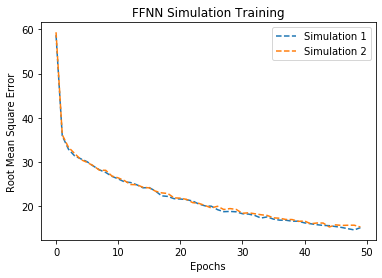

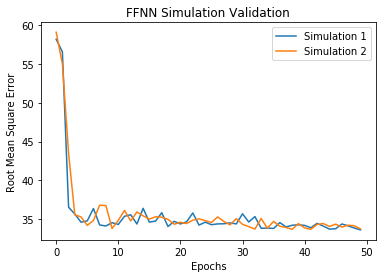

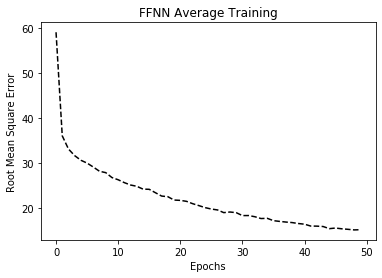

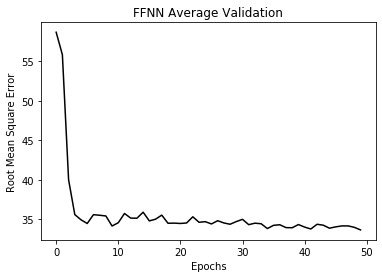

In [55]:
k = 5
n_simulations = 5
epochs = 200
batchsize = 64
sim_train = np.zeros((n_simulations, epochs))
sim_test = np.zeros((n_simulations, epochs))
simulation_list = []

for sim in range(n_simulations):
    model_sim_best, Ltrain, Ltest, lowest_val = FFNN(vector_train, labels_train, epochs, k, batchsize, sim)
    
    # Testing model
    m_label = np.mean(vector_test)
    s_label = np.std(vector_test)
    X_model = norm(vector_test, m_label, s_label)
    R = model_sim_best.evaluate(X_model, labels_test, verbose = 0)
    simulation_list.append(R[0])
    
    if sim == 0:
        model_best = model_sim_best
        val_marker = lowest_val
    else:
        if lowest_val < val_marker:
            model_best = model_sim_best
            val_marker = lowest_val
    
    sim_train[sim] = np.mean(Ltrain, axis = 0)
    sim_test[sim] = np.mean(Ltest, axis = 0)
    
    plt.figure(1)
    plt.plot(range(epochs), sim_train[sim], '--', label = 'Simulation {}'.format(sim+1))
    plt.figure(2)
    plt.plot(range(epochs), sim_test[sim], label = 'Simulation {}'.format(sim+1))

    
plt.figure(3)    
plt.plot(range(epochs), np.mean(sim_train, axis = 0), 'k--')
plt.figure(4)    
plt.plot(range(epochs), np.mean(sim_test, axis = 0), 'k')

clear_output()

titles = ['FFNN Simulation Training', 'FFNN Simulation Validation','FFNN Average Training', 'FFNN Average Validation']
for i in range(4):
    plt.figure(i+1)
    plt.title(titles[i])
    plt.xlabel('Epochs')
    plt.ylabel('Root Mean Square Error')
    if i == 0 or i == 1:     
        plt.legend()   
        
overfit = np.sqrt(simulation_list) - np.min(sim_train, axis = 1)        
train_min_mean = np.mean(np.min(sim_train, axis = 1))
train_min_std = np.std(np.min(sim_train, axis = 1))
test_min_mean = np.mean(np.min(sim_test, axis = 1))
test_min_std = np.std(np.min(sim_test, axis = 1))
print('Final Training Mean RMSE:',train_min_mean)
print('Final Training STD RMSE:',train_min_std)
print('Final Validation Mean RMSE:',test_min_mean)
print('Final Validation STD RMSE:',test_min_std)
print('The Final Mean RMSE', np.mean(np.sqrt(simulation_list)))
print('The Final STD RMSE', np.std(np.sqrt(simulation_list)))
print('Overfit Mean', np.mean(overfit))
print('Overfit STD', np.std(overfit))
#-----------------Saving model------------------
# serialize model to JSON
model_json = model_best.to_json()
with open("FFNN_model_best.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_best.save_weights("FFNN_model_best.h5")
print("Saved model to disk")

In [56]:
def prune(model):
    epochs_prune = 1
    batch = 1000
    end_step = np.ceil(1.0 * len(vector_train)/batch).astype(np.int32) * epochs_prune
    new_pruning_params = {'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity = 0.25,
                                                       final_sparsity = 0.25,
                                                       begin_step = 0,
                                                       end_step = end_step,
                                                       frequency = 100)}

    new_pruned_model = sparsity.prune_low_magnitude(model, **new_pruning_params)
    new_pruned_model.compile(loss = tf.keras.losses.mean_squared_error, optimizer = 'adam', metrics=['mse'])
    callbacks = [sparsity.UpdatePruningStep()]
    new_pruned_model.fit(vector_train, labels_train,
              batch_size = batch,
              epochs = epochs_prune,
              verbose = 1,
              callbacks = callbacks)
    #           validation_data = (x_val, y_val))

    clear_output()
    final_model = sparsity.strip_pruning(new_pruned_model)
    score = new_pruned_model.evaluate(vector_test, labels_test, verbose = 0)
    print('initial test RMSE = {:.2f}'.format(np.mean(np.sqrt(simulation_list))))
    print('The final test RMSE on the model is {:.2f}'.format(np.sqrt(score[0])))
    
    return new_pruned_model

prune(model_best)

initial test RMSE = 91.97
The final test RMSE on the model is 220.29
